<div style="color:#800080; font-size:28px; font-weight:bold;">
    1. Título y datos del alumno    
</div>

**Título: Predecir la aparición de diabetes basándose en medidas de diagnóstico**
  
**Autores:**  
- Cisneros Lovaton, Sarai
- Urbina Castro, George

<div style="color:#800080; font-size:28px; font-weight:bold;">
    2. Introducción y Contexto del Negocio  
</div>

**Contexto**  
El Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales quiere predecir diagnósticamente si un paciente padece diabetes, basándose en ciertas mediciones diagnósticas. En particular, todos los pacientes aquí presentes son mujeres de al menos 21 años de ascendencia indígena pima.

**Definición de variables:**

Variables Predictoras:
- Pregnancies: Número de veces que quedó embarazada
- Glucose: Concentración de glucosa plasmática a las 2 horas en una prueba de tolerancia a la glucosa oral
- BloodPressure: Presión arterial diastólica (mm Hg)
- SkinThickness: Espesor del pliegue cutáneo del tríceps (mm)
- Insulin: Insulina sérica de 2 horas (mu U/ml)
- BMI: Índice de masa corporal (peso en kg/(altura en m)^2)
- DiabetesPedigreeFunction: Función del pedigrí de la diabetes
- Age: Edad (años) 

Variable Objetivo (Target):
- Outcome (0: No tiene diabetes / 1: Tiene diabetes)


**Pregunta de negocio que intentas responder:**  
¿Puede construir un modelo de aprendizaje automático para predecir con precisión si los pacientes en el conjunto de datos tienen diabetes o no?

<div style="color:#800080; font-size:28px; font-weight:bold;">
    3. Carga de datos
</div>

In [ ]:
# 1. Configuración Inicial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # Agregado para visualizaciones
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
# Agregado ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from category_encoders import TargetEncoder
import joblib
import time
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.dummy import DummyClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report)

import seaborn as sns
from sklearn import set_config


# Semilla aleatoria
RANDOM_STATE = 42

In [81]:
!pip install kagglehub

In [82]:
import os
import kagglehub

# Cambiar ruta de almacenamiento
os.environ["KAGGLEHUB_CACHE"] = "../data/"
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")

print("Descargado en:", path)

Descargado en: ../data/datasets\uciml\pima-indians-diabetes-database\versions\1


In [83]:
df = pd.read_csv("../data/datasets/uciml/pima-indians-diabetes-database/versions/1/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [84]:
# Ver columnas disponibles
print("Columnas:", df.columns.tolist()[:10], "...")
print(f"Dimensiones: {df.shape}")

# Separar Features y Target(Outcome)
TARGET_COL = 'Outcome'
COLS_TO_DROP = [TARGET_COL]

# Eliminamos explícitamente columnas que no aportan valor predictivo o son identificadores.
X = df.drop([col for col in COLS_TO_DROP if col in df.columns], axis=1)
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

print(f"\nTrain shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Distribución target (Train): {y_train.value_counts(normalize=True).to_dict()}")
print("")

X_train.info()


Columnas: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'] ...
Dimensiones: (768, 9)

Train shape: (614, 8)
Test shape: (154, 8)
Distribución target (Train): {0: 0.6514657980456026, 1: 0.3485342019543974}

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, 353 to 107
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               614 non-null    int64  
 1   Glucose                   614 non-null    int64  
 2   BloodPressure             614 non-null    int64  
 3   SkinThickness             614 non-null    int64  
 4   Insulin                   614 non-null    int64  
 5   BMI                       614 non-null    float64
 6   DiabetesPedigreeFunction  614 non-null    float64
 7   Age                       614 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 43.2 KB


<div style="color:#800080; font-size:28px; font-weight:bold;">
    4. Explotación de Datos (EDA)
</div>

In [85]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
print("Columnas Numéricas detectadas:", num_cols)

# columnas que en Pima usan 0 como indicador implícito de NA
suspect_zero_cols = [c for c in ['Glucose','BloodPressure','SkinThickness','Insulin','BMI'] if c in num_cols]
print("")
print("Columnas donde 0 puede significar missing:", suspect_zero_cols)
print("")
for c in suspect_zero_cols:
    zeros = (X_train[c] == 0).sum()
    print(f"  {c}: zeros = {zeros} ({zeros/len(X_train)*100:.2f}%)")

Columnas Numéricas detectadas: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

Columnas donde 0 puede significar missing: ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

  Glucose: zeros = 4 (0.65%)
  BloodPressure: zeros = 23 (3.75%)
  SkinThickness: zeros = 175 (28.50%)
  Insulin: zeros = 290 (47.23%)
  BMI: zeros = 9 (1.47%)


In [86]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,614.0,3.819218,3.314148,0.000,1.000,3.0000,6.00000,17.000
Glucose,614.0,120.908795,31.561093,0.000,99.000,117.0000,140.00000,199.000
BloodPressure,614.0,69.442997,18.402581,0.000,62.500,72.0000,80.00000,122.000
SkinThickness,614.0,20.776873,15.856433,0.000,0.000,23.0000,32.00000,99.000
Insulin,614.0,78.666124,107.736572,0.000,0.000,40.5000,130.00000,744.000
BMI,614.0,31.973290,7.861364,0.000,27.500,32.3000,36.50000,67.100
DiabetesPedigreeFunction,614.0,0.477428,0.330300,0.084,0.245,0.3825,0.63925,2.329
Age,614.0,33.366450,11.833438,21.000,24.000,29.0000,41.00000,81.000


In [87]:
# Identificar tipos de columnas automáticamente
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Features numéricas ({len(num_features)}): {num_features[:10]}...")
print(f"Features categóricas ({len(cat_features)}): {cat_features[:10] if cat_features else 'Ninguna'}")

# Verificar valores nulos
null_pct = (X_train.isnull().sum() / len(X_train)
            * 100).sort_values(ascending=False)
print(f"\nColumnas con más nulos:\n{null_pct.head()}")



Features numéricas (8): ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']...
Features categóricas (0): Ninguna

Columnas con más nulos:
Pregnancies      0.0
Glucose          0.0
BloodPressure    0.0
SkinThickness    0.0
Insulin          0.0
dtype: float64


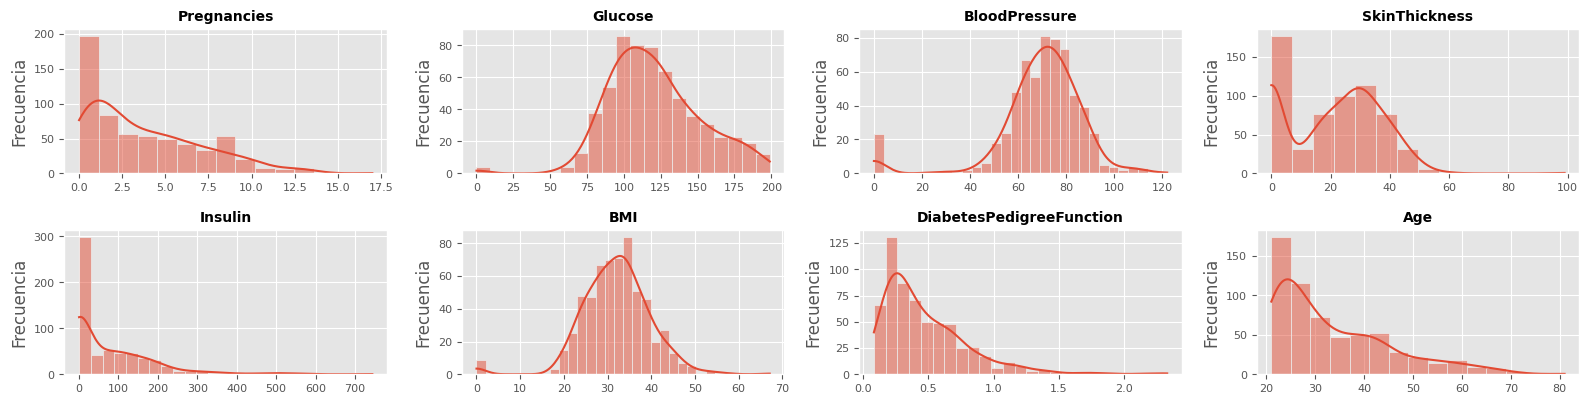

In [88]:
import seaborn as sns
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

def plot_numeric_distributions(x):
    # Seleccionar columnas numéricas
    columnas_numeric = num_features #x.select_dtypes(include=['float64', 'int64']).columns

    # Número de variables numéricas
    num_vars = len(columnas_numeric)

    # Calcular el número de filas y columnas
    ncols = 4
    nrows = int(np.ceil(num_vars / ncols))

    # Crear subgráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 2))
    axes = axes.flatten()  # Aplanar la matriz de ejes para fácil indexación

    # Graficar histogramas
    for i, colum in enumerate(columnas_numeric):
        sns.histplot(data=x, x=colum, kde=True, ax=axes[i])
        axes[i].set_title(colum, fontsize=10, fontweight="bold")
        axes[i].tick_params(labelsize=8)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Frecuencia")

    # Ocultar ejes extra
    for ax in axes[num_vars:]:
        ax.axis('off')

    fig.tight_layout()
    plt.subplots_adjust(top=0.95)
    #fig.suptitle('Distribución de variables numéricas', fontsize=12, fontweight="bold")
    plt.show()

plot_numeric_distributions(X_train)

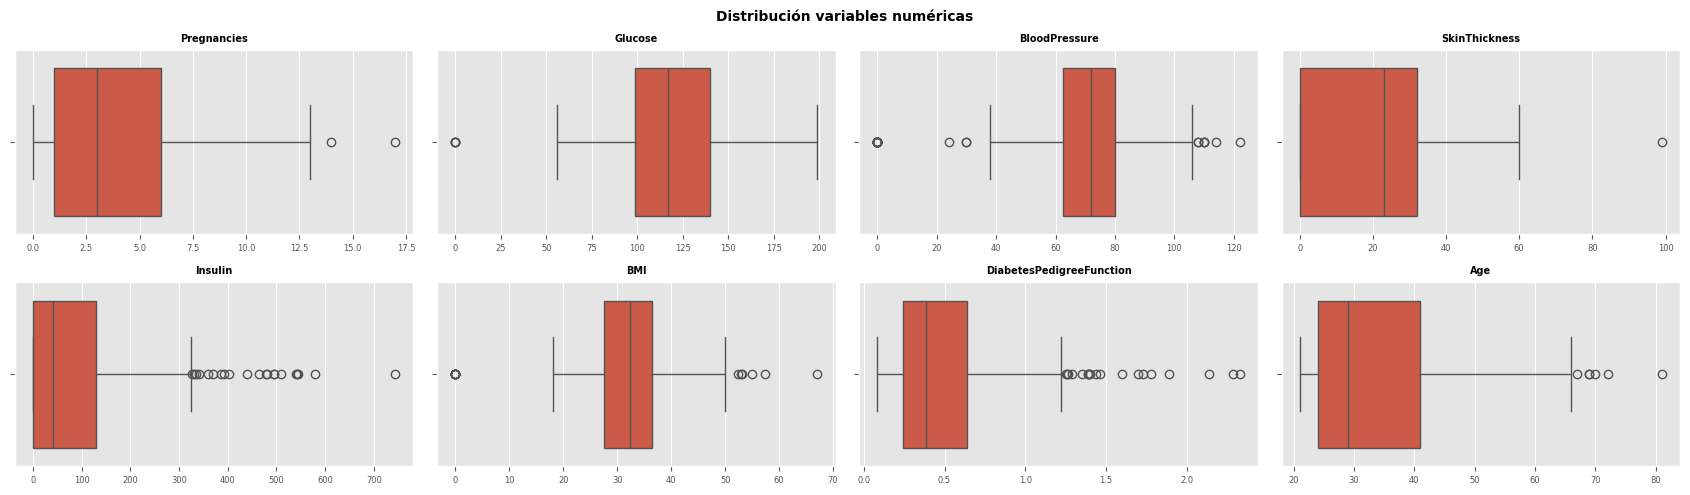

In [89]:
# Ajustar el número de subplots en función del número de columnas numéricas
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(17, 5))
axes = axes.flat
columnas_numeric = num_features #df.select_dtypes(include=['float64', 'int64']).drop(columns=['Outcome']).columns

for i, colum in enumerate(columnas_numeric):
    sns.boxplot(data=X_train, x=colum, ax=axes[i])
    axes[i].set_title(colum, fontsize=7, fontweight="bold")
    axes[i].tick_params(labelsize=6)
    axes[i].set_xlabel("")

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables numéricas', fontsize=10, fontweight="bold")
plt.show()


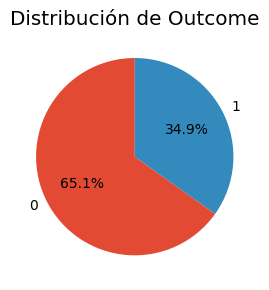

In [90]:
conteo = y_train.value_counts()

plt.figure(figsize=(3,3))
plt.pie(
    conteo.values,
    labels=conteo.index,
    autopct='%1.1f%%',
    startangle=90
)

plt.title("Distribución de Outcome")
plt.tight_layout()
plt.show()

<div style="color:#800080; font-size:28px; font-weight:bold;">
    5. Preprocesamiento (Pipeline)
</div>

In [ ]:
cols_validar_ceros = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
cols_no_validar_ceros = ['Pregnancies','DiabetesPedigreeFunction','Age']

# Pipeline para columnas con ceros sospechosos
pipeline_ceros = Pipeline([
    ('imputer', SimpleImputer(missing_values=0, strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para columnas sin ceros sospechosos
pipeline_normales = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('pipeline_ceros', pipeline_ceros, cols_validar_ceros),
        ('pipeline_normales', pipeline_normales, cols_no_validar_ceros)
    ],
    verbose_feature_names_out=False,
    remainder='drop'  # Lo que no listamos, se borra
)

# Visualizar el preprocesador (sin ajustar aún)
preprocessor

,transformers,"[('pipeline_ceros', ...), ('pipeline_normales', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,missing_values,0
,strategy,'median'
,fill_value,None


<div style="color:#800080; font-size:28px; font-weight:bold;">
    6. Modelado y Baseline
</div>

In [133]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons

N_ESTIMATORS = 100
MAX_DEPTH = 5 
LEARNING_RATE = 0.1

model_TreeSimple = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

model_RandomForest = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
model_Gradient = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

import xgboost as xgb
# Calcular scale_pos_weight para desbalanceo
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model_XGBoost = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier())
])

from sklearn.svm import SVC
model_svm =  Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons

N_ESTIMATORS = 100
MAX_DEPTH = 5 
LEARNING_RATE = 0.1

model_TreeSimple = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        max_depth=MAX_DEPTH,
        min_samples_leaf=1,
        random_state=RANDOM_STATE))
])

model_RandomForest = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=N_ESTIMATORS, 
        max_depth=MAX_DEPTH,
        min_samples_leaf=1, 
        class_weight='balanced', 
        n_jobs=-1, 
        random_state=RANDOM_STATE))
])

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
model_Gradient = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        n_estimators=N_ESTIMATORS, 
        learning_rate=LEARNING_RATE, 
        max_depth=MAX_DEPTH, 
        random_state=RANDOM_STATE))
])

import xgboost as xgb
# Calcular scale_pos_weight para desbalanceo
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model_XGBoost = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        n_estimators=N_ESTIMATORS, 
        learning_rate=LEARNING_RATE,
        max_depth=MAX_DEPTH,
        scale_pos_weight=scale_pos_weight,  # Balance de clases
        use_label_encoder=False,        
        random_state=RANDOM_STATE, 
        eval_metric='logloss',
        #eval_metric='auc',
        verbosity=0))
])

from sklearn.svm import SVC
model_svm =  Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        kernel='rbf',
        C=1.0,
        gamma=0.5,
        random_state=RANDOM_STATE))
])

In [134]:
# Modelos a comparar
modelos = {    
    'Arbol Simple': model_TreeSimple,
    'Random Forest': model_RandomForest,
    'Gradient': model_Gradient,
    'XGBoost': model_XGBoost,
    'SVM': model_svm
}

resultados_comparacion = []

for nombre, modelo in modelos.items():
    start_time = time.time() # tiempo de inicio
    modelo.fit(X_train, y_train) # entrenamiento
    time_result = time.time() - start_time # tiempo de término

    y_pred = modelo.predict(X_test) # pred    

    resultados_comparacion.append({
        'Modelo': nombre,
        'Accuracy': accuracy_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred),
        'Tiempo (s)': time_result
    })    

In [138]:
# Crear DataFrame de resultados
df_results = pd.DataFrame(resultados_comparacion)
df_results['Accuracy'] = df_results['Accuracy'].round(4)
df_results['AUC'] = df_results['AUC'].round(4)
df_results['Tiempo (s)'] = df_results['Tiempo (s)'].round(3)

# Identificar ganadores
best_auc_idx = df_results['AUC'].idxmax()
fastest_idx = df_results['Tiempo (s)'].idxmin()

print("=" * 60)
print("🏆 TABLA DE RESULTADOS")
print("=" * 60)
print(df_results.to_string(index=False))
print("\n")
print(
    f"🥇 Mejor AUC: {df_results.loc[best_auc_idx, 'Modelo']} ({df_results.loc[best_auc_idx, 'AUC']:.4f})")
print(
    f"⚡ Más Rápido: {df_results.loc[fastest_idx, 'Modelo']} ({df_results.loc[fastest_idx, 'Tiempo (s)']:.2f}s)")

🏆 TABLA DE RESULTADOS
       Modelo  Accuracy    AUC  Tiempo (s)
 Arbol Simple    0.6948 0.6415       0.088
Random Forest    0.7468 0.7070       0.318
     Gradient    0.7597 0.7170       0.219
      XGBoost    0.7662 0.7306       0.119
          SVM    0.7403 0.6978       0.043


🥇 Mejor AUC: XGBoost (0.7306)
⚡ Más Rápido: SVM (0.04s)


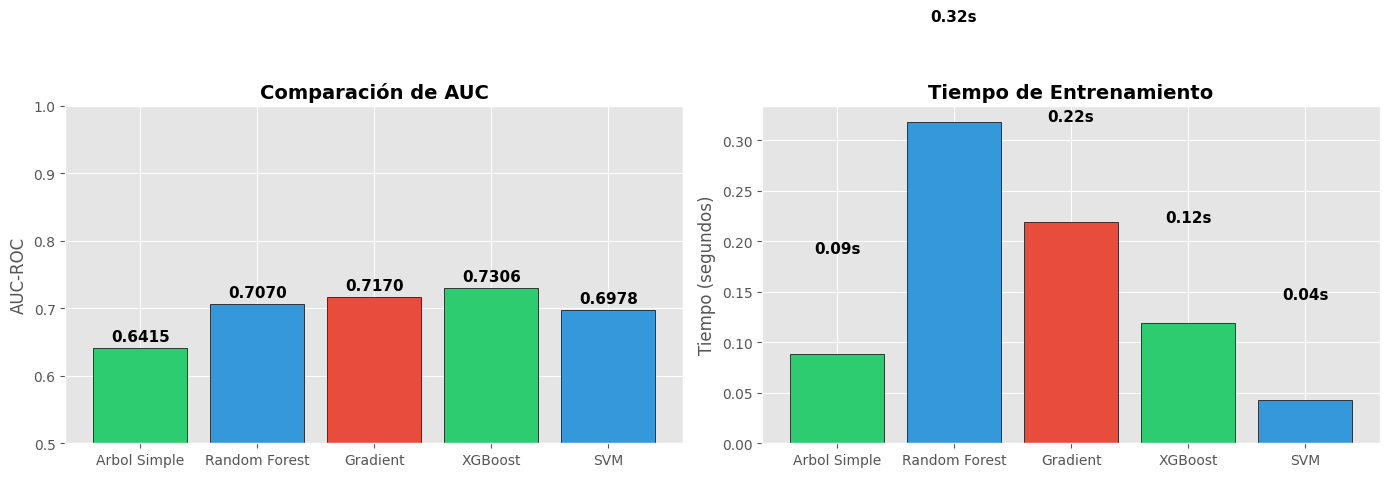

In [139]:
# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#2ecc71', '#3498db', '#e74c3c']  # Verde, Azul, Rojo

# Gráfico 1: AUC
ax1 = axes[0]
bars1 = ax1.bar(df_results['Modelo'], df_results['AUC'],
                color=colors, edgecolor='black')
ax1.set_ylabel('AUC-ROC', fontsize=12)
ax1.set_title('Comparación de AUC', fontsize=14, fontweight='bold')
ax1.set_ylim(0.5, 1.0)
for bar, val in zip(bars1, df_results['AUC']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.4f}', ha='center', fontsize=11, fontweight='bold')

# Gráfico 2: Tiempo
ax2 = axes[1]
bars2 = ax2.bar(
    df_results['Modelo'], df_results['Tiempo (s)'], color=colors, edgecolor='black')
ax2.set_ylabel('Tiempo (segundos)', fontsize=12)
ax2.set_title('Tiempo de Entrenamiento', fontsize=14, fontweight='bold')
for bar, val in zip(bars2, df_results['Tiempo (s)']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{val:.2f}s', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons

model_TreeSimple = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        
        random_state=RANDOM_STATE))
])

model_RandomForest = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        
        random_state=RANDOM_STATE))
])

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
model_Gradient = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        
        random_state=RANDOM_STATE))
])

import xgboost as xgb
# Calcular scale_pos_weight para desbalanceo
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model_XGBoost = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
                
        random_state=RANDOM_STATE))
])

from sklearn.svm import SVC
model_svm =  Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        
        random_state=RANDOM_STATE))
])

In [100]:
# =============================================
# 🎯 EJEMPLO 3: Dummy vs Modelo Real
# =============================================

# Modelos a comparar
modelos = {    
    #'Logistic Regression': model_Logistic,
    'Arbol Simple': model_TreeSimple,
    'Random Forest': model_RandomForest,
    'Gradient': model_Gradient,
    'XGBoost': model_XGBoost,
    'SVM': model_svm
}

resultados_comparacion = []

for nombre, modelo in modelos.items():
    start_time = time.time() # tiempo de inicio
    modelo.fit(X_train, y_train) # entrenamiento
    time_result = time.time() - start_time # tiempo de término

    y_pred = modelo.predict(X_test) # pred    

    resultados_comparacion.append({
        'Modelo': nombre,
        'Accuracy': accuracy_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred),
        'Tiempo (s)': time_result
    })

In [101]:
# Crear DataFrame de resultados
df_results = pd.DataFrame(resultados_comparacion)
df_results['Accuracy'] = df_results['Accuracy'].round(4)
df_results['AUC'] = df_results['AUC'].round(4)
df_results['Tiempo (s)'] = df_results['Tiempo (s)'].round(3)

# Identificar ganadores
best_auc_idx = df_results['AUC'].idxmax()
fastest_idx = df_results['Tiempo (s)'].idxmin()

print("=" * 60)
print("🏆 TABLA DE RESULTADOS")
print("=" * 60)
print(df_results.to_string(index=False))
print("\n")
print(
    f"🥇 Mejor AUC: {df_results.loc[best_auc_idx, 'Modelo']} ({df_results.loc[best_auc_idx, 'AUC']:.4f})")
print(
    f"⚡ Más Rápido: {df_results.loc[fastest_idx, 'Modelo']} ({df_results.loc[fastest_idx, 'Tiempo (s)']:.2f}s)")

🏆 TABLA DE RESULTADOS
       Modelo  Accuracy    AUC  Tiempo (s)
 Arbol Simple    0.6688 0.6172       0.022
Random Forest    0.7273 0.6878       0.236
     Gradient    0.7792 0.7406       0.223
      XGBoost    0.7662 0.7306       0.075
          SVM    0.7403 0.6978       0.034


🥇 Mejor AUC: Gradient (0.7406)
⚡ Más Rápido: Arbol Simple (0.02s)


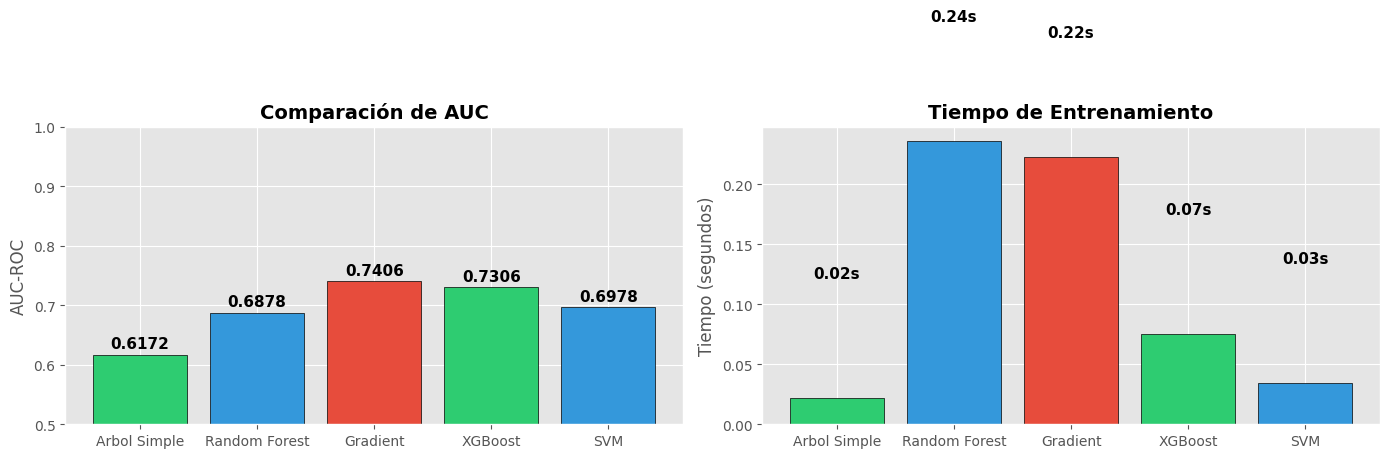

In [102]:
# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#2ecc71', '#3498db', '#e74c3c']  # Verde, Azul, Rojo

# Gráfico 1: AUC
ax1 = axes[0]
bars1 = ax1.bar(df_results['Modelo'], df_results['AUC'],
                color=colors, edgecolor='black')
ax1.set_ylabel('AUC-ROC', fontsize=12)
ax1.set_title('Comparación de AUC', fontsize=14, fontweight='bold')
ax1.set_ylim(0.5, 1.0)
for bar, val in zip(bars1, df_results['AUC']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.4f}', ha='center', fontsize=11, fontweight='bold')

# Gráfico 2: Tiempo
ax2 = axes[1]
bars2 = ax2.bar(
    df_results['Modelo'], df_results['Tiempo (s)'], color=colors, edgecolor='black')
ax2.set_ylabel('Tiempo (segundos)', fontsize=12)
ax2.set_title('Tiempo de Entrenamiento', fontsize=14, fontweight='bold')
for bar, val in zip(bars2, df_results['Tiempo (s)']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{val:.2f}s', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


<div style="color:#800080; font-size:28px; font-weight:bold;">
    7. Evaluación y métricas
</div>

In [ ]:
# =============================================
# 🎯 EJEMPLO 3: Dummy vs Modelo Real
# =============================================

# Modelos a comparar
modelos = {    
    #'Logistic Regression': model_Logistic,
    'Arbol Simple': model_TreeSimple,
    'Random Forest': model_RandomForest,
    'Gradient': model_Gradient,
    'XGBoost': model_XGBoost,
    'SVM': model_svm
}

resultados_comparacion = []

for nombre, modelo in modelos.items():
    start_time = time.time() # tiempo de inicio
    modelo.fit(X_train, y_train) # entrenamiento
    time_result = time.time() - start_time # tiempo de término

    y_pred = modelo.predict(X_test) # pred    

    resultados_comparacion.append({
        'Modelo': nombre,
        'Accuracy': accuracy_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred),
        'Tiempo (s)': time_result
    })    

df_comp = pd.DataFrame(resultados_comparacion)
print('###' * 30)
print("📊 COMPARACIÓN: \n")
print(df_comp.to_string(index=False))
print('###' * 30)
# print("\n💡 Si tu modelo no supera al Dummy, ¡no está aprendiendo!")

print('')

In [120]:
# Crear DataFrame de resultados
df_results = pd.DataFrame(resultados_comparacion)
df_results['Accuracy'] = df_results['Accuracy'].round(4)
df_results['AUC'] = df_results['AUC'].round(4)
df_results['Tiempo (s)'] = df_results['Tiempo (s)'].round(3)

# Identificar ganadores
best_auc_idx = df_results['AUC'].idxmax()
fastest_idx = df_results['Tiempo (s)'].idxmin()

print("=" * 60)
print("🏆 TABLA DE RESULTADOS")
print("=" * 60)
print(df_results.to_string(index=False))
print("\n")
print(f"🥇 Mejor AUC: {df_results.loc[best_auc_idx, 'Modelo']} ({df_results.loc[best_auc_idx, 'AUC']:.4f})")
print(f"⚡ Más Rápido: {df_results.loc[fastest_idx, 'Modelo']} ({df_results.loc[fastest_idx, 'Tiempo (s)']:.2f}s)")

🏆 TABLA DE RESULTADOS
       Modelo  Accuracy    AUC  Tiempo (s)
 Arbol Simple    0.6688 0.6172       0.022
Random Forest    0.7273 0.6878       0.236
     Gradient    0.7792 0.7406       0.223
      XGBoost    0.7662 0.7306       0.075
          SVM    0.7403 0.6978       0.034


🥇 Mejor AUC: Gradient (0.7406)
⚡ Más Rápido: Arbol Simple (0.02s)


TypeError: list indices must be integers or slices, not str

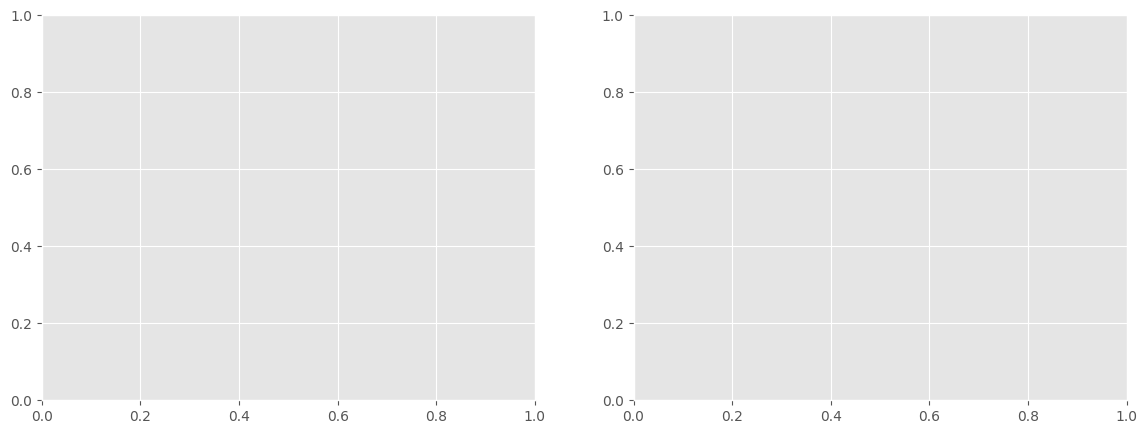

In [119]:
# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#2ecc71', '#3498db', '#e74c3c']  # Verde, Azul, Rojo

# Gráfico 1: AUC
ax1 = axes[0]
bars1 = ax1.bar(resultados_comparacion['Modelo'], resultados_comparacion['AUC'],
                color=colors, edgecolor='black')
ax1.set_ylabel('AUC-ROC', fontsize=12)
ax1.set_title('Comparación de AUC', fontsize=14, fontweight='bold')
ax1.set_ylim(0.5, 1.0)
for bar, val in zip(bars1, resultados_comparacion['AUC']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.4f}', ha='center', fontsize=11, fontweight='bold')

# Gráfico 2: Tiempo
ax2 = axes[1]
bars2 = ax2.bar(
    resultados_comparacion['Modelo'], resultados_comparacion['Tiempo (s)'], color=colors, edgecolor='black')
ax2.set_ylabel('Tiempo (segundos)', fontsize=12)
ax2.set_title('Tiempo de Entrenamiento', fontsize=14, fontweight='bold')
for bar, val in zip(bars2, resultados_comparacion['Tiempo (s)']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{val:.2f}s', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


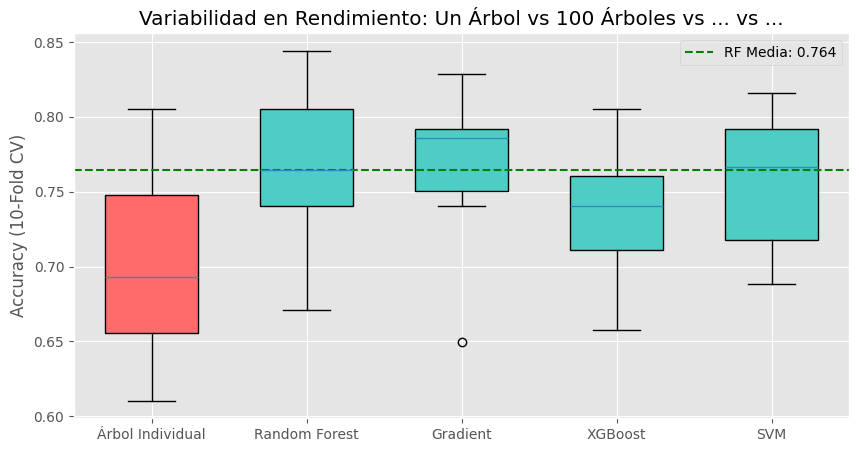

📊 Árbol_Individual: 0.701 ± 0.058
📊 Random_Forest:    0.764 ± 0.053
📊 Gradient:    0.768 ± 0.047
📊 XGBoost:    0.736 ± 0.040
📊 SVM:    0.757 ± 0.046


In [140]:
from sklearn.model_selection import train_test_split, cross_val_score

# Comparar estabilidad con Cross-Validation
tree_scores = cross_val_score(model_TreeSimple, X, y, cv=10)
rf_scores = cross_val_score(model_RandomForest, X, y, cv=10)
gradient_scores = cross_val_score(model_Gradient, X, y, cv=10)
xgboost_scores = cross_val_score(model_XGBoost, X, y, cv=10)
svn_scores = cross_val_score(model_svm, X, y, cv=10)


fig, ax = plt.subplots(figsize=(10, 5))
positions = [1, 2, 3, 4, 5]
bp = ax.boxplot([tree_scores, rf_scores, gradient_scores, xgboost_scores, svn_scores], positions=positions, widths=0.6, patch_artist=True)

colors = ['#FF6B6B', '#4ECDC4', '#4ECDC4', '#4ECDC4', '#4ECDC4', '#4ECDC4']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticks(positions)
ax.set_xticklabels(['Árbol Individual', 'Random Forest', 'Gradient', 'XGBoost', 'SVM'])
ax.set_ylabel('Accuracy (10-Fold CV)')
ax.set_title('Variabilidad en Rendimiento: Un Árbol vs 100 Árboles vs ... vs ...')
ax.axhline(y=np.mean(rf_scores), color='green', linestyle='--',
           label=f'RF Media: {np.mean(rf_scores):.3f}')
ax.legend()
plt.show()

print(f"📊 Árbol_Individual: {np.mean(tree_scores):.3f} ± {np.std(tree_scores):.3f}")
print(f"📊 Random_Forest:    {np.mean(rf_scores):.3f} ± {np.std(rf_scores):.3f}")
print(f"📊 Gradient:    {np.mean(gradient_scores):.3f} ± {np.std(gradient_scores):.3f}")
print(f"📊 XGBoost:    {np.mean(xgboost_scores):.3f} ± {np.std(xgboost_scores):.3f}")
print(f"📊 SVM:    {np.mean(svn_scores):.3f} ± {np.std(svn_scores):.3f}")


<div style="color:#800080; font-size:28px; font-weight:bold;">
    5. Ajuste Manual de Hiperparámetros    
</div>

In [118]:
from sklearn.model_selection import GridSearchCV

#Definir la grilla de hiperparámetros
param_grid = {
    'classifier__n_estimators': [1,20,50,100,200],
    'classifier__max_depth': [None, 3,5],
    'classifier__min_samples_split': [2,4],
    'classifier__min_samples_leaf': [1,2]
}

#Configurar GridSearchCV
grid_rf = GridSearchCV(
    estimator=model_RandomForest,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'roc_auc': 'roc_auc'
    },
    refit='roc_auc',   # 👈 métrica para seleccionar el mejor modelo
    cv=5,
    n_jobs=-1,
    verbose=1
)

#Entrenar GridSearch
grid_rf.fit(X_train, y_train)

#Mejores resultados
print("Mejores hiperparámetros:")
print(grid_rf.best_params_)

print("\nMejor score CV:")
print(grid_rf.best_score_)

# Mejor modelo entrenado
best_rf = grid_rf.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Mejores hiperparámetros:
{'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 200}

Mejor score CV:
0.8389313399778515


In [112]:
results = pd.DataFrame(grid_rf.cv_results_)

tabla_resultados = results[
    [
        'param_classifier__n_estimators',
        'param_classifier__max_depth',
        'param_classifier__min_samples_split',
        'param_classifier__min_samples_leaf',
        'mean_test_accuracy',
        'std_test_accuracy',
        'mean_test_roc_auc',
        'std_test_roc_auc',
        'rank_test_roc_auc'
    ]
].sort_values('rank_test_roc_auc')

# Renombrar columnas
tabla_resultados = tabla_resultados.rename(columns={
    'param_classifier__n_estimators': 'N Trees',
    'param_classifier__max_depth': 'Max Depth',
    'param_classifier__min_samples_split': 'Min Split',
    'param_classifier__min_samples_leaf': 'Min Leaf',
    'mean_test_accuracy': 'Mean Accuracy',
    'std_test_accuracy': 'Std Accuracy',
    'mean_test_roc_auc': 'Mean ROC_AUC',
    'std_test_roc_auc': 'Std ROC_AUC',
    'rank_test_roc_auc': 'Rank (ROC_AUC)'
})

print("\n📊 Resultados GridSearch Random Forest:\n")
print(tabla_resultados.to_string(index=False))


📊 Resultados GridSearch Random Forest:

 N Trees Max Depth  Min Split  Min Leaf  Mean Accuracy  Std Accuracy  Mean ROC_AUC  Std ROC_AUC  Rank (ROC_AUC)
     200         5          4         1       0.770438      0.026367      0.838931     0.016374               1
     100         3          2         2       0.762268      0.019618      0.838659     0.017019               2
     100         3          4         2       0.762268      0.019618      0.838659     0.017019               2
     200         5          2         1       0.772065      0.028131      0.838642     0.017797               4
     100         3          4         1       0.763908      0.022432      0.838142     0.017695               5
     200         5          2         2       0.767173      0.027478      0.838051     0.017273               6
     200         5          4         2       0.767173      0.027478      0.838051     0.017273               6
     100         3          2         1       0.763908      0.0

<div style="color:#800080; font-size:28px; font-weight:bold;">
    6. Interpretabilidad
</div>

C:\Users\Usuario\AppData\Local\Temp\ipykernel_12728\3771646991.py:19: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Usuario\miniconda3\envs\ml_pro\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


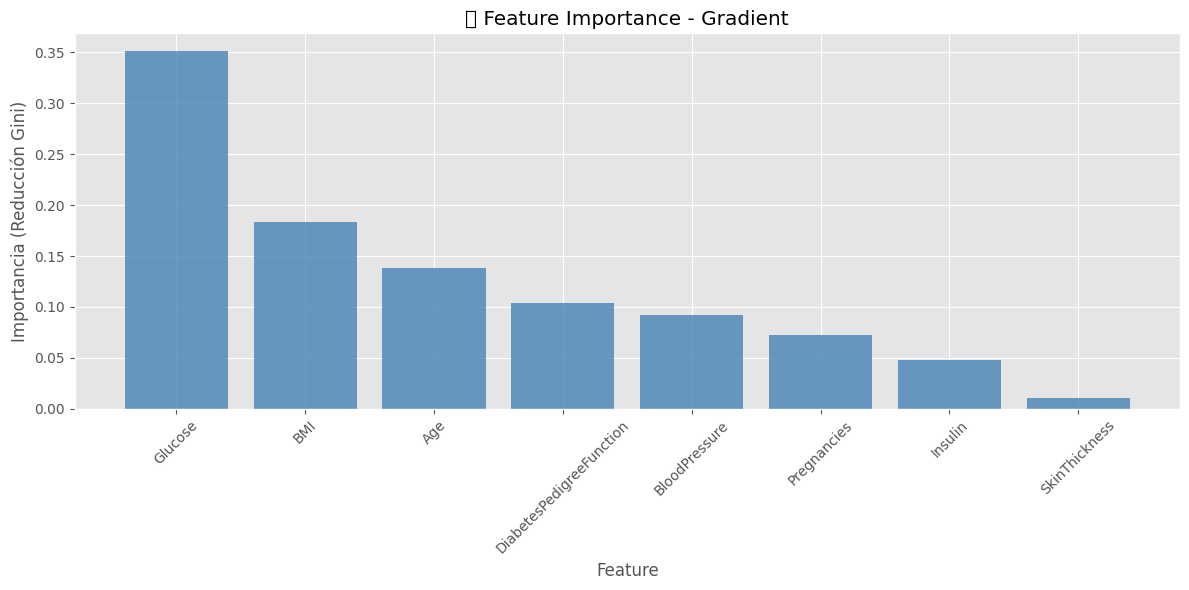

🔍 Las primeras 5 features fueron creadas como 'informativas'.
   El modelo las identifica correctamente como las más importantes.


In [113]:
# Generar datos con más features
from sklearn.datasets import make_classification

model_Gradient.fit(X_train, y_train)

rf_multi = model_TreeSimple.named_steps['classifier']
feature_names = model_TreeSimple.named_steps['preprocessor'].get_feature_names_out()

# Plot importancia
importances = rf_multi.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.bar(range(8), importances[indices], color='steelblue', alpha=0.8)
plt.xticks(range(8), [feature_names[i] for i in indices], rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importancia (Reducción Gini)')
plt.title('📊 Feature Importance - Gradient')
plt.tight_layout()
plt.show()

print("🔍 Las primeras 5 features fueron creadas como 'informativas'.")
print("   El modelo las identifica correctamente como las más importantes.")


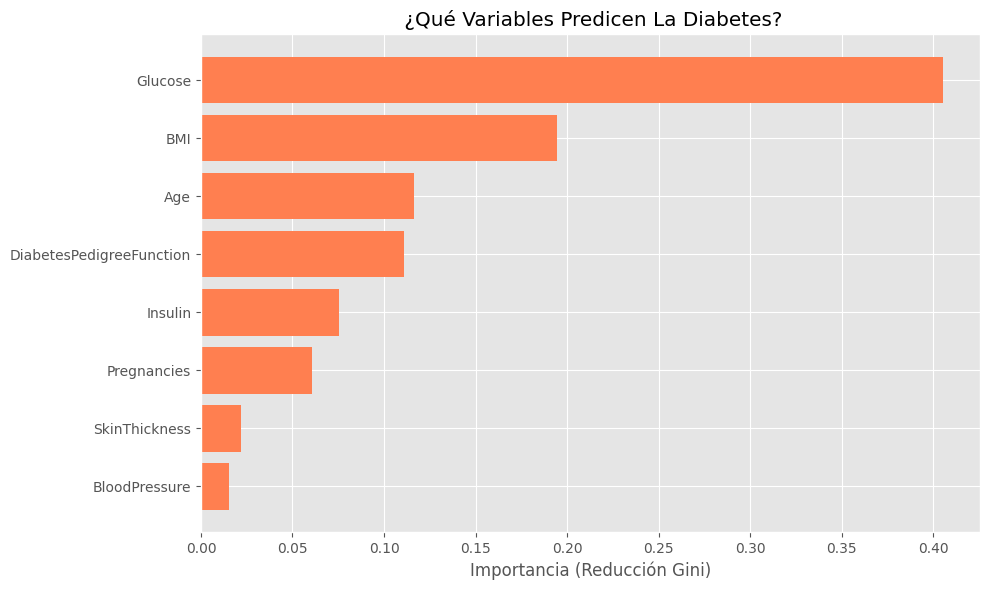

In [ ]:
feature_names = model_TreeSimple.named_steps['preprocessor'].get_feature_names_out()

# Feature Importance
importances = model_Gradient.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_names)), importances[indices], color='coral')
plt.yticks(range(len(feature_names)), [feature_names[i] for i in indices])
plt.xlabel('Importancia (Reducción Gini)')
plt.title(' ¿Qué Variables Predicen La Diabetes?')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Árbol Simple
ax1 = axes[0]




In [ ]:
# Feature Importance del mejor modelo (LightGBM)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# LightGBM Feature Importance
lgb.plot_importance(lgbm, max_num_features=15, ax=axes[0],
                    title='LightGBM - Feature Importance')

# XGBoost Feature Importance
xgb.plot_importance(xgb_model, max_num_features=15, ax=axes[1],
                    title='XGBoost - Feature Importance')

plt.tight_layout()
plt.show()

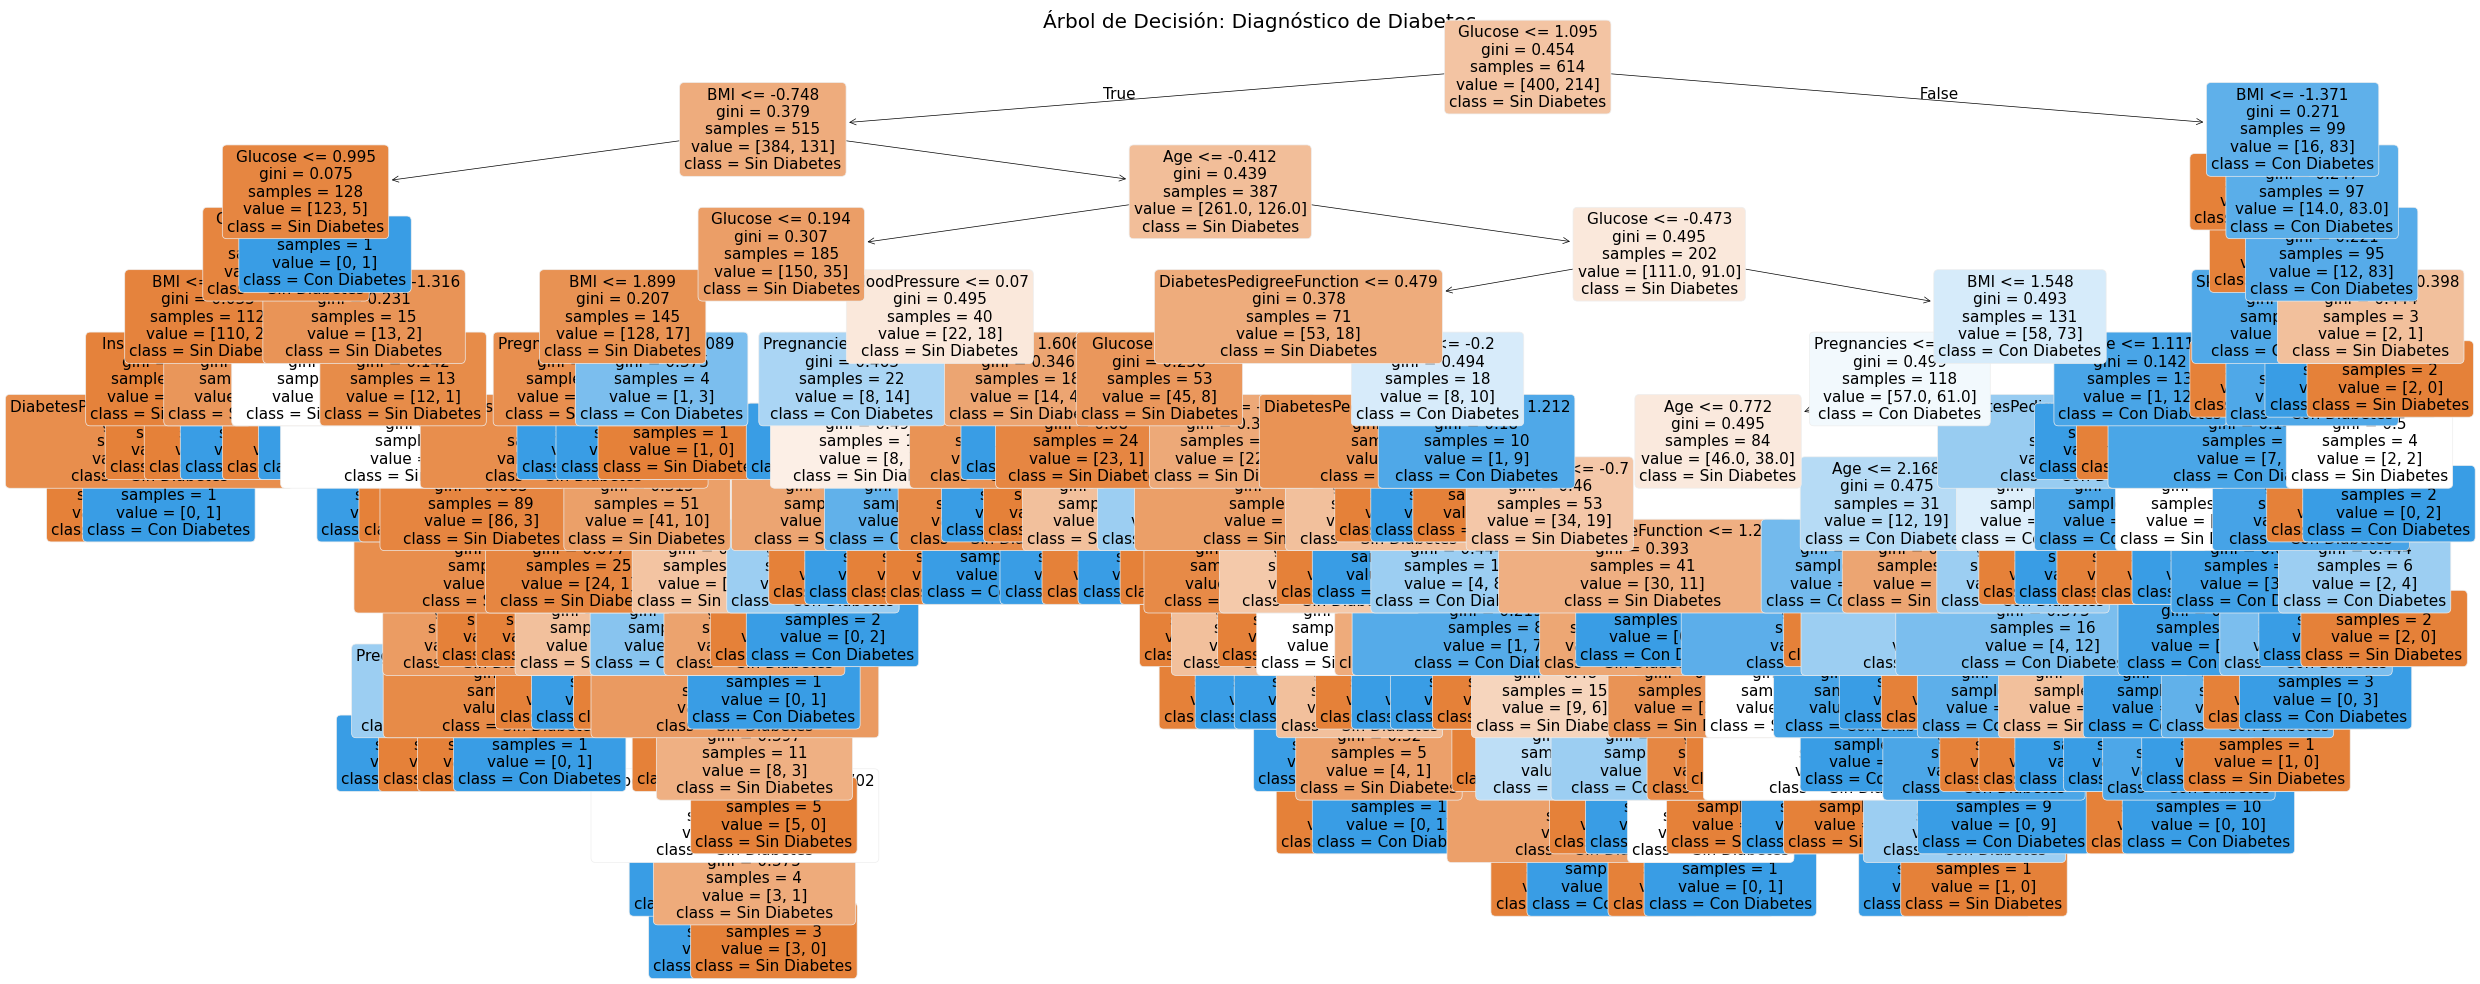

In [117]:
tree_diabetes = model_TreeSimple.named_steps['classifier']

# Visualizar árbol
plt.figure(figsize=(25, 10))
plot_tree(tree_diabetes,
          feature_names=feature_names,
          class_names=['Sin Diabetes', 'Con Diabetes'],
          filled=True,
          rounded=True,
          fontsize=11)
plt.title('Árbol de Decisión: Diagnóstico de Diabetes')
plt.tight_layout()
plt.show()

<div style="color:#800080; font-size:28px; font-weight:bold;">
    7. Conclusiones
</div>

¿Qué modelo recomiendas para producción y por qué?  
Trade-offs observados (accuracy vs interpretabilidad, tiempo de entrenamiento, etc.)  
Próximos pasos sugeridos  

<div style="color:#800080; font-size:28px; font-weight:bold;">
    8. Referencias
</div>

Link: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

In [ ]:
import sys
import os
import pickle
import json
import time

# ========================================
# MÉTODO 2: JOBLIB (Estándar ML)
# ========================================
joblib_path = '../app/models/model_joblib.joblib'
auc = roc_auc_score(y_test, model_Logistic.predict_proba(X_test)[:, 1])

# Guardar CON metadatos (buena práctica)
artifact = {
    'model': model_Logistic,
    'feature_names': X.columns.tolist(),
    'target_col': TARGET_COL,
    'auc_test': auc,
    'training_date': pd.Timestamp.now().isoformat(),
    'python_version': sys.version
    #'lightgbm_version': lgb.__version__
}

start = time.time()
joblib.dump(artifact, joblib_path, compress=3)  # compress=3 es buen balance
joblib_save_time = time.time() - start

# Cargar
start = time.time()
loaded_artifact = joblib.load(joblib_path)
joblib_load_time = time.time() - start

model_joblib = loaded_artifact['model']

# Verificar
pred_joblib = model_joblib.predict_proba(X_test)[:, 1]
auc_joblib = roc_auc_score(y_test, pred_joblib)

joblib_size = os.path.getsize(joblib_path) / 1024

print(f"📁 Archivo: {joblib_path}")
print(f"📦 Tamaño: {joblib_size:.2f} KB (comprimido)")
print(f"⏱️ Tiempo guardar: {joblib_save_time*1000:.2f} ms")
print(f"⏱️ Tiempo cargar: {joblib_load_time*1000:.2f} ms")
print(f"✅ AUC verificado: {auc_joblib:.4f}")
print(f"\n📋 Metadatos guardados: {list(loaded_artifact.keys())}")

In [ ]:
import sklearn

# ========================================
# MÉTODO 5B: JSON + Metadatos (Para APIs)
# ========================================
json_path = '../app/models/model_metadata.json'

# Guardar metadatos en JSON (legible por cualquier lenguaje)
metadata = {
    'model_type': 'LogisticRegression',
    'model_file': 'model_texto.txt',
    'feature_names': X.columns.tolist(),
    'n_features': len(X.columns.tolist()),
    'target_col': TARGET_COL,
    
    'metrics': {
        'auc_test': round(auc, 4),
        'n_train_samples': len(X_train),
        'n_test_samples': len(X_test)
    },
    
    'training_info': {
        'date': pd.Timestamp.now().isoformat(),
        'version': sklearn.__version__        
    },
    
    #'feature_importance': dict(zip(
    #    X.columns.tolist(),
    #    model_Logistic_pipeline.feature_importances_.tolist()
    #))
}

with open(json_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"📁 Metadatos guardados: {json_path}")
print(f"\n📋 Contenido:")
print(json.dumps(metadata, indent=2)[:1000] + "...")